In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'cyclegan' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
BUFFER_SIZE = 400
IMG_SIZE = 256 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 3

Path(MASTER_FOLDER).mkdir(parents=True, exist_ok=True)

In [3]:
# Funkcije za ucitavanje podataka
dataset_dictionary = {
    'horse2zebra': (r'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip', True)
}

def download_dataset(dataset_name: str) -> None:
    assert dataset_name in dataset_dictionary, 'Izabran skup podataka ne postoji'
    dataset_url, zipped = dataset_dictionary[dataset_name]
    keras.utils.get_file(origin=dataset_url, extract=zipped, cache_dir=MASTER_FOLDER, cache_subdir='datasets')
    return f'{MASTER_FOLDER}/datasets/{dataset_name}'

def load_image(image_file: str) -> tf.Tensor:
    # Ucitavanje slike
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_data(path: str) -> np.ndarray:
    dataset = tf.data.Dataset.list_files(f'{path}/*.jpg')
    dataset = dataset.map(load_image)
    dataset = dataset.shuffle(BUFFER_SIZE)
    return dataset.batch(BATCH_SIZE)

def load_dataset(dataset_name: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dataset_path = download_dataset(dataset_name)
    trainA = load_data(f'{dataset_path}/trainA')
    trainB = load_data(f'{dataset_path}/trainB')
    testA = load_data(f'{dataset_path}/testA')
    testB = load_data(f'{dataset_path}/testB')
    tf_train = tf.data.Dataset.zip((trainA, trainB))
    tf_test = tf.data.Dataset.zip((testA, testB))
    return tf_train, tf_test

tf_train, tf_test = load_dataset('horse2zebra')

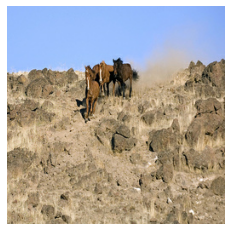

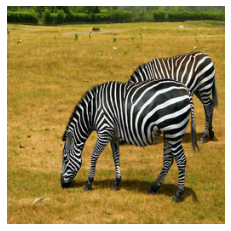

In [4]:
from library.visualization import show_image

for x, y in tf_train.take(1):
    assert x.shape == y.shape and x.shape == (40, IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
    show_image(x[10])
    show_image(y[10])

In [5]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    
    generator_builder.add_downsample_layer(64, 4, apply_batchnorm=False)
    generator_builder.add_downsample_layer(128, 4)
    generator_builder.add_downsample_layer(256, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    generator_builder.add_downsample_layer(512, 4)
    
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4, apply_dropout=True)
    generator_builder.add_upsample_layer(512, 4)
    generator_builder.add_upsample_layer(256, 4)
    generator_builder.add_upsample_layer(128, 4)
    generator_builder.add_upsample_layer(64, 4)
    
    return generator_builder.build()

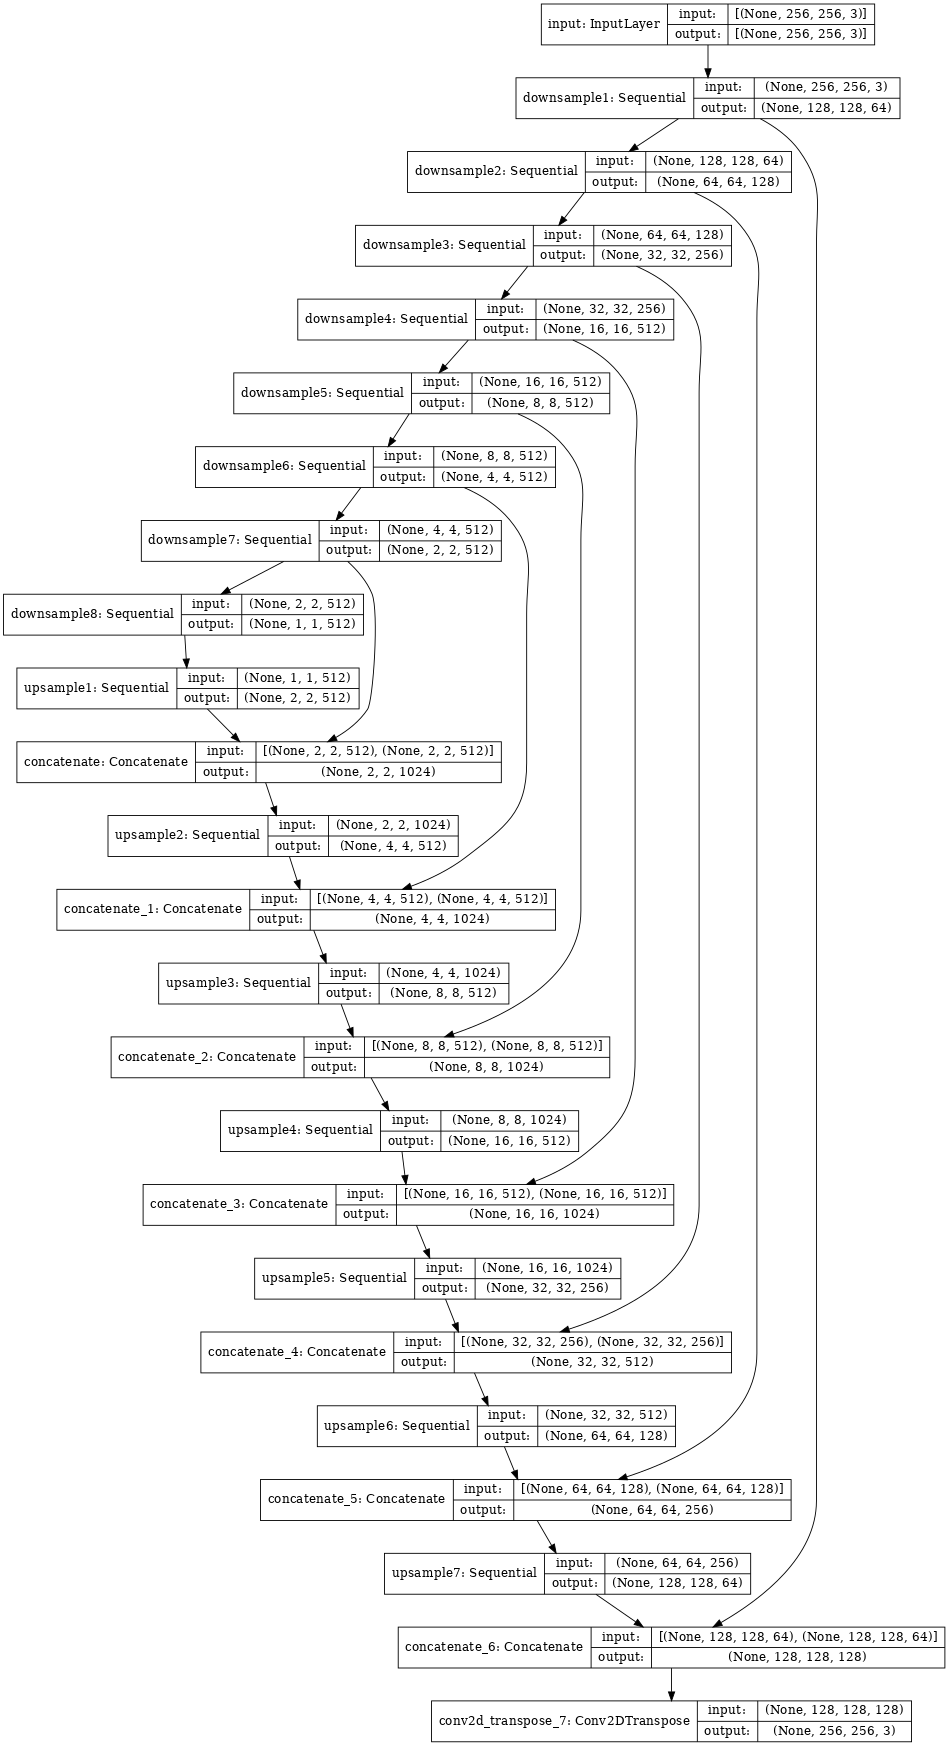

In [6]:
generator_g = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
generator_f = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

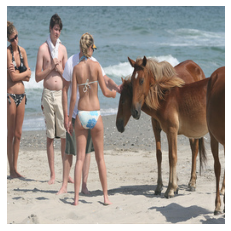

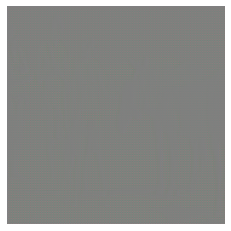

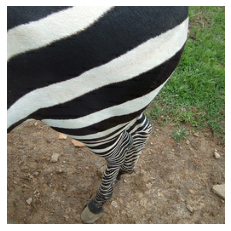

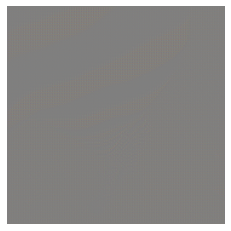

In [7]:
for x, y in tf_train.take(1):
    show_image(x[3])
    show_image(generator_g(x)[3])
    show_image(y[3])
    show_image(generator_f(y)[3])

In [8]:
from library.unet_generator import downsample

def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 3], name='input_image')
    x = inputs 

    x = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    x = downsample(128, 4)(x)  # (batch_size, 64, 64, 128)
    x = downsample(256, 4)(x)  # (batch_size, 32, 32, 256)
    zero_pad1 = layers.ZeroPadding2D()(x)  # (batch_size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)  # (batch_size, 30, 30, 1)
    return tf.keras.Model(inputs=inputs, outputs=last)

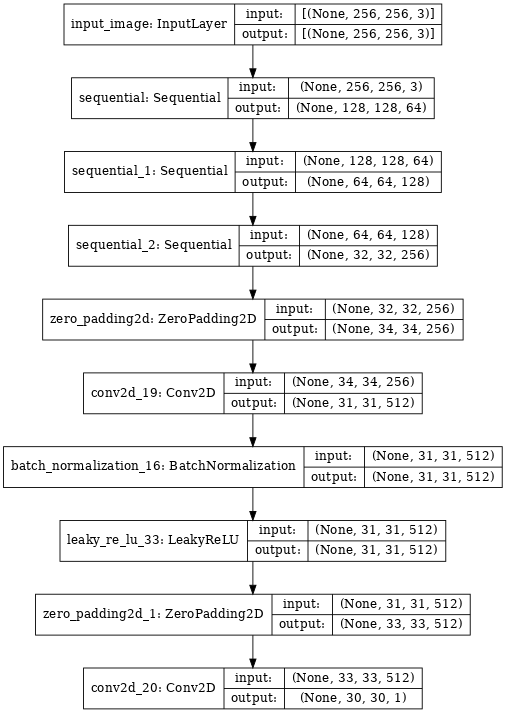

In [9]:
discriminator_x = create_discriminator(input_size=IMG_SIZE)
discriminator_y = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

In [10]:
# Podesavanje optimizatora
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [11]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [12]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

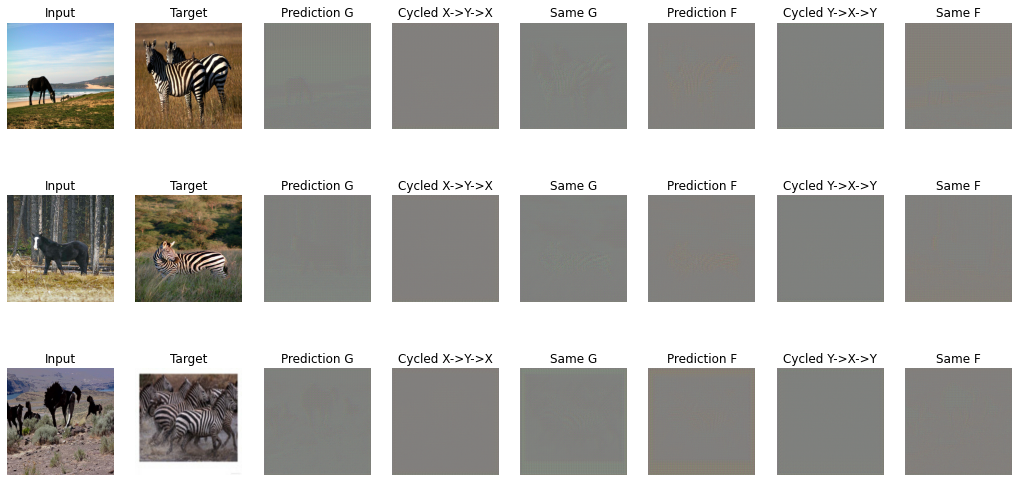

Step: 1


In [ ]:
from library.cyclegan.cyclegan import CycleGAN

cyclegan = CycleGAN(
    gen_g = generator_g,
    gen_f = generator_f,
    disc_x = discriminator_x,
    disc_y = discriminator_y,
    gen_g_optim = generator_g_optimizer,
    gen_f_optim = generator_f_optimizer,
    disc_x_optim = discriminator_x_optimizer,
    disc_y_optim = discriminator_y_optimizer,
    summary_writer = summary_writer,
    checkpoint = checkpoint,
    checkpoint_prefix = checkpoint_prefix,
    img_size=IMG_SIZE
)

cyclegan.fit(tf_train, tf_test, steps=10, test_generation_period=1, n_test_examples=3)